In [1]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from pennylane import qaoa as qaoa
import networkx as nx

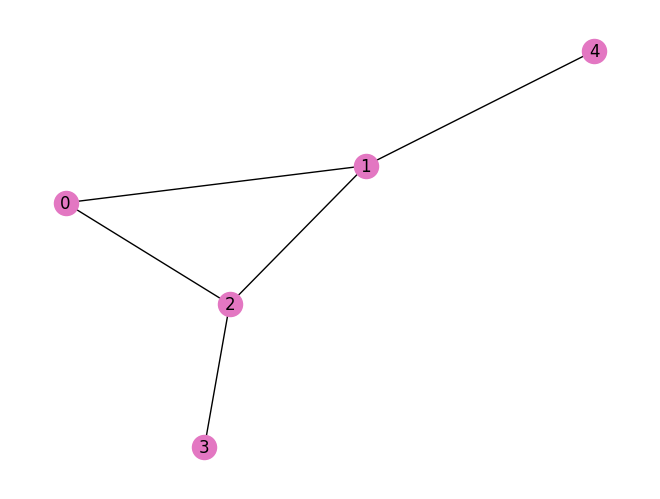

In [ ]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4)] #Defines the list of edges that will make up the graph. Each pair has a connection between two nodes.
graph = nx.Graph(edges) #Creates an undirected graph (Graph) object from the given edge list using NetworkX.   undirected graph :A to B, B to A
positions = nx.spring_layout(graph, seed=1) #Calculates the layout (node positions) using the spring layout algorithm.Set Random seed=1 ensures consistent layout every time.
nx.draw(graph, with_labels=True, node_color="#e377c2", pos=positions) #show node labels,set node color to pink,use the previously calculated layout
plt.show()

In [3]:
cost_h, driver_h = qaoa.max_clique(graph, constrained=False)

print("Cost Hamiltonian")
print(cost_h)
print("Driver Hamiltonian")
print(driver_h)

Cost Hamiltonian
0.75 * (Z(0) @ Z(3)) + -0.75 * Z(0) + -0.75 * Z(3) + 0.75 * (Z(0) @ Z(4)) + -0.75 * Z(0) + -0.75 * Z(4) + 0.75 * (Z(1) @ Z(3)) + -0.75 * Z(1) + -0.75 * Z(3) + 0.75 * (Z(2) @ Z(4)) + -0.75 * Z(2) + -0.75 * Z(4) + 0.75 * (Z(3) @ Z(4)) + -0.75 * Z(3) + -0.75 * Z(4) + 1.0 * Z(0) + 1.0 * Z(1) + 1.0 * Z(2) + 1.0 * Z(3) + 1.0 * Z(4)
Driver Hamiltonian
1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3) + 1 * X(4)


In [4]:
def build_hamiltonian(graph):
    H = qml.Hamiltonian([], [])

    # Computes the complement of the graph
    graph_c = nx.complement(graph)

    for k in graph_c.nodes:
        # Adds the terms in the first sum
        for edge in graph_c.edges:
            i, j = edge
            if k == i:
                H += 6 * (qml.PauliY(k) @ qml.PauliZ(j) - qml.PauliY(k))
            if k == j:
                H += 6 * (qml.PauliZ(i) @ qml.PauliY(k) - qml.PauliY(k))
        # Adds the terms in the second sum
        H += 6 * qml.PauliY(k)

    return H


print("MaxClique Commutator")
print(build_hamiltonian(graph))

MaxClique Commutator
1.0 * 6 * (Y(0) @ Z(3) + -1 * Y(0)) + 1.0 * 6 * (Y(0) @ Z(4) + -1 * Y(0)) + 1.0 * 6 * Y(0) + 1.0 * 6 * (Y(1) @ Z(3) + -1 * Y(1)) + 1.0 * 6 * Y(1) + 1.0 * 6 * (Y(2) @ Z(4) + -1 * Y(2)) + 1.0 * 6 * Y(2) + 1.0 * 6 * (Z(0) @ Y(3) + -1 * Y(3)) + 1.0 * 6 * (Z(1) @ Y(3) + -1 * Y(3)) + 1.0 * 6 * (Y(3) @ Z(4) + -1 * Y(3)) + 1.0 * 6 * Y(3) + 1.0 * 6 * (Z(0) @ Y(4) + -1 * Y(4)) + 1.0 * 6 * (Z(2) @ Y(4) + -1 * Y(4)) + 1.0 * 6 * (Z(3) @ Y(4) + -1 * Y(4)) + 1.0 * 6 * Y(4)


In [5]:
def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, delta_t * beta_k, 1)

In [6]:
def build_maxclique_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        layers = len(beta)
        for w in dev.wires:
            qml.Hadamard(wires=w)
        qml.layer(
            falqon_layer,
            layers,
            beta,
            cost_h=cost_h,
            driver_h=driver_h,
            delta_t=delta_t
        )

    return ansatz


def expval_circuit(beta, measurement_h):
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

In [7]:
def max_clique_falqon(graph, n, beta_1, delta_t, dev):
    comm_h = build_hamiltonian(graph) # Builds the commutator
    cost_h, driver_h = qaoa.max_clique(graph, constrained=False) # Builds H_c and H_d
    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd") # The ansatz + measurement circuit is executable

    beta = [beta_1] # Records each value of beta_k
    energies = [] # Records the value of the cost function at each step

    for i in range(n):
        # Adds a value of beta to the list and evaluates the cost function
        beta.append(-1 * cost_fn(beta, measurement_h=comm_h))  # this call measures the expectation of the commuter hamiltonian
        energy = cost_fn(beta, measurement_h=cost_h)  # this call measures the expectation of the cost hamiltonian
        energies.append(energy)

    return beta, energies

In [8]:
n = 40
beta_1 = 0.0
delta_t = 0.03

dev = qml.device("default.qubit", wires=graph.nodes) # Creates a device for the simulation
res_beta, res_energies = max_clique_falqon(graph, n, beta_1, delta_t, dev)

In [9]:
@qml.qnode(dev, interface="autograd")
def prob_circuit():
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    ansatz(res_beta)
    return qml.probs(wires=dev.wires)

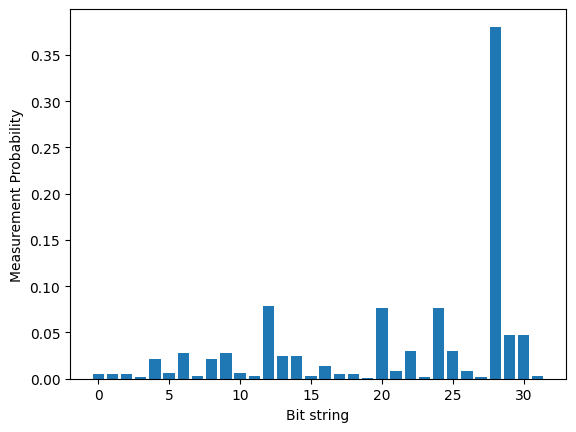

In [10]:
probs = prob_circuit()
plt.bar(range(2**len(dev.wires)), probs)
plt.xlabel("Bit string")
plt.ylabel("Measurement Probability")
plt.show()

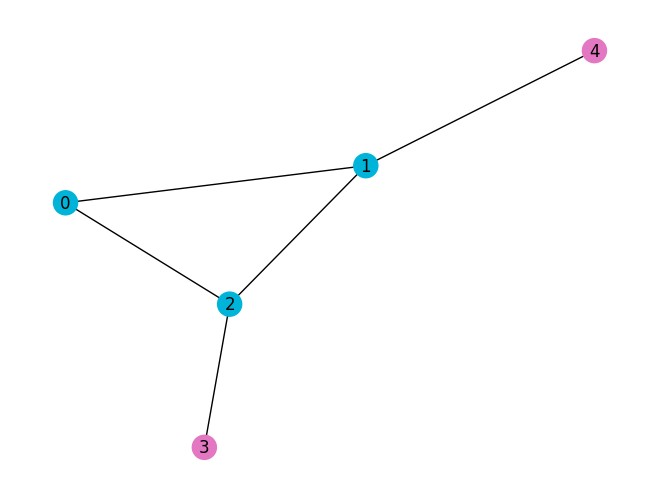

In [11]:
graph = nx.Graph(edges)
cmap = ["#00b4d9"]*3 + ["#e377c2"]*2
positions = nx.spring_layout(graph, seed=1)
nx.draw(graph, with_labels=True, node_color=cmap, pos=positions)
plt.show()